# Coursework 1
**Replace CID in the file name with your CID**

CID: 02216531

# Outline


- [Task 1](#task-1): Multi-class classification with Decision Trees and Random Forests <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
  - [(1.4)](#task-14) <a name="index-task-14"></a>
- [Task 2](#task-2): Binary classification with the Huberised Support Vector Machine <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>
- [Task 3](#task-3): Regression with the Multi-Layer Perceptron <a name="index-task-3"></a>
  - [(3.1)](#task-31) <a name="index-task-31"></a>
  - [(3.2)](#task-32)  <a name="index-task-32"></a>



---



<a name="task-1"></a>

# Task 1: Multi-class classification with Decision Trees and Random Forests  [(index)](#index-task-1)

Let us first import all necessary libraries and create a random generator with a fixed seed $0$ as required.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng(0)

Then we import the training set and the test set, and we preview both of the datasets to familiarise its structure.

In [2]:
data_train = pd.read_csv("airfield_statistics_train.csv")
data_test = pd.read_csv("airfield_statistics_test.csv")

In [3]:
data_train.head()

,Days of airfrost,Precipitation,Sunshine hours,Humidity (%),Wind Speed,Aircraft total movements,Weather and flight condition category,Runway surface minimal temperature,Runway surface maximal temperature
0,24,59.9,58.5,79.3,5.1,1347,3,-2.6,3.8
1,0,66.7,158.3,61.0,3.5,1306,1,11.5,20.0
2,0,39.5,194.6,57.9,3.2,1284,0,8.6,16.8
3,0,34.0,192.8,60.2,2.6,1270,1,12.2,22.4
4,8,17.7,50.3,79.7,2.9,1319,3,2.3,9.5


In [4]:
data_test.head()

,Days of airfrost,Precipitation,Sunshine hours,Humidity (%),Wind Speed,Aircraft total movements,Weather and flight condition category,Runway surface minimal temperature,Runway surface maximal temperature
0,0,29.8,187.7,59.1,2.5,1303,1,12.5,20.9
1,28,12.9,38.4,71.6,5.1,1261,3,-4.6,0.8
2,2,87.0,200.6,56.6,4.0,1345,0,7.2,15.9
3,7,69.7,66.9,57.5,4.4,1241,0,2.8,8.4
4,0,49.6,119.0,59.6,3.7,1341,0,5.8,13.1


We also want to set a global configuration for $\verb|matplotlib|$ to obtain well-readable plots as before.

In [5]:
# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

For the first part, we use the first $6$ columns as features $X$, and we consider 'Weather and flight condition category' to be the class label (target) $y$, as required.

In [6]:
features = ["Days of airfrost", "Precipitation", "Sunshine hours", "Humidity (%)", "Wind Speed", "Aircraft total movements"]
target = "Weather and flight condition category"
X_train = data_train[features].values
y_train = data_train[target].values
X_test = data_test[features].values
y_test = data_test[target].values

We are instructed to use Gini index as the loss function for each node split, which we will implement as follows.

In [7]:
def gini_index(y):
    """
    Calculate the Gini index.
    Arguments:
        y: target
    Returns:
        Gini index
    """
    # Count occurrences of each unique label in y
    _, counts = np.unique(y, return_counts=True)

    # Compute probability for each class
    p = counts / len(y)

    # Compute the sum of squared probabilities and return the Gini index
    return 1 - np.sum(p**2)

In [8]:
def gini_split(X, y, min_samples_leaf):
    """
    Choose the best feature to split according to criterion using the Gini index.
    Arguments:
        X: features
        y: target
        min_samples_leaf: minimum number of samples in a leaf node
    Returns:
        split_feature: index of the best feature to split
        split_threshold: threshold of the best feature to split
    """
    # Initialise variables
    gini, split_feature, split_threshold = np.inf, None, None

    # Iterate over each feature
    for feature in range(X.shape[1]):
        # Iterate over each unique value
        for threshold in np.unique(X[:, feature]):
            # Split the dataset
            left_mask = X[:, feature] < threshold

            # Skip if minimum number of samples is not met
            if sum(left_mask) < min_samples_leaf or sum(~left_mask) < min_samples_leaf:
                continue

            # Calculate the Gini index for each dataset and the weighted Gini index
            gini_left = gini_index(y[left_mask])
            gini_right = gini_index(y[~left_mask])
            weighted_gini = (sum(left_mask) * gini_left + sum(~left_mask) * gini_right) / len(y)

            # Update the best split if a lower Gini index is found
            if weighted_gini < gini:
                gini = weighted_gini
                split_feature = feature
                split_threshold = threshold
    
    # Return the best feature and threshold to split
    return split_feature, split_threshold

We then build the decision tree and use it to predict the target variable using the same method as the notebook.

In [9]:
def build_tree(X, y, depth, max_depth, min_samples_leaf):
    """
    Build the decision tree using recursion.
    Arguments:
        X: features
        y: target
        depth: current depth for this node
        max_depth: maximum depth of the tree
        min_samples_leaf: minimum number of samples in a leaf node
    Returns:
        (dict): a dictionary denoting the decision tree. Each parent node has 4 attributes:
            1. feature: the feature to split on
            2. threshold: the threshold to split the feature
            3. left: the left child node
            4. right: the right child node
    """
    # Return the majority vote if the stopping criteria are met
    # i.e., all targets are the same, maximum depth is reached, or minimum number of samples is met
    if len(np.unique(y)) == 1 or depth > max_depth or len(y) <= min_samples_leaf:
        return np.bincount(y).argmax()

    # Find the best feature and threshold to split
    feature, threshold = gini_split(X, y, min_samples_leaf)

    # Return the majority vote if the best is not found
    if feature is None:
        return np.bincount(y).argmax()

    # Split the dataset and build the tree
    left_mask = X[:, feature] <= threshold
    return {
        "feature": feature,
        "threshold": threshold,
        "left": build_tree(X[left_mask], y[left_mask], depth + 1, max_depth, min_samples_leaf),
        "right": build_tree(X[~left_mask], y[~left_mask], depth + 1, max_depth, min_samples_leaf),
    }

In [10]:
def predict_single(x, node):
    """
    Predict for a single data sample.
    Arguments:
        x: a single data sample
        node: a node in the decision tree
    Returns:
        prediction
    """
    # Recursively traverse the tree until a leaf node is reached
    if isinstance(node, dict):
        if x[node["feature"]] <= node["threshold"]:
            return predict_single(x, node["left"])
        else:
            return predict_single(x, node["right"])
    else:
        return node

def predict_DT(X, tree):
    """
    Predict for multiple samples.
    Arguments:
        X: features
        tree: a decision tree
    Returns:
        predictions
    """
    # Predict for each sample
    return np.array([predict_single(x, tree) for x in X])

We now train the decision tree with $\verb|max_depth=10|$ and $\verb|min_samples_leaf=12|$, and calculate the accuracy by comparison.

In [11]:
# Train the decision tree for the given dataset
tree = build_tree(X_train, y_train, depth=0, max_depth=10, min_samples_leaf=12)

# Calculate the accuracy
print(np.mean(predict_DT(X_train, tree) == y_train))
print(np.mean(predict_DT(X_test, tree) == y_test))

0.8686514886164624
0.8244897959183674


The accuracy of the decision tree on the training and test sets is therefore $86.87\%$ and $82.45\%$, respectively.

We then standardise the dataset and calculate the corresponding accuracy.

In [12]:
# Calculate the mean and standard deviation
mean_X = np.mean(X_train, axis=0)
std_X = np.std(X_train, axis=0)

# Standardise the training and test sets
X_train_std = (X_train - mean_X) / std_X
X_test_std = (X_test - mean_X) / std_X

In [13]:
# Train the decision tree for the standardised dataset
tree_std = build_tree(X_train_std, y_train, depth=0, max_depth=10, min_samples_leaf=12)

# Calculate the accuracy
print(np.mean(predict_DT(X_train_std, tree_std) == y_train))
print(np.mean(predict_DT(X_test_std, tree_std) == y_test))

0.8686514886164624
0.8244897959183674


We can see that the accuracy is unaffected by standardisation.
This is expected because decision trees split the data based on feature thresholds rather than distance metrics, so they are invariant with scaling.

We then move on to the next part. We use the Euclidean distance to implement a $k$-Nearest Neighbour ($k$-NN) classifier.

In [14]:
def euclidean_distance(a, b):
    """
    Calculate Euclidean distance.
    Arguments:
        a: array a
        b: array b
    Returns:
        Euclidean distance
    """
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

In [15]:
def predict_kNN(X_train, y_train, X_test, k):
    """
    Predict using k-Nearest Neighbors.
    Arguments:
        X_train: training features
        y_train: training target
        X_test: test features
        k: number of neighbors
    Returns:
        predictions
    """
    # Initialise the predictions
    y_pred = np.zeros(len(X_test))

    # Iterate over each test sample
    for i, x in enumerate(X_test):
        # Calculate the Euclidean distance
        distances = euclidean_distance(X_train, x)

        # Find the k-nearest neighbors
        nearest_indices = np.argsort(distances)[:k]

        # Make the prediction
        y_pred[i] = np.bincount(y_train[nearest_indices]).argmax()

    # Return the predictions
    return y_pred

We can now calculate the accuracy of the $k$-Nearest Neighbour classifier with and without standardisation.

In [16]:
# Train the k-NN without standardisation and calculate the accuracy
print(np.mean(predict_kNN(X_train, y_train, X_train, k=25) == y_train))
print(np.mean(predict_kNN(X_train, y_train, X_test, k=25) == y_test))

0.6112084063047285
0.6040816326530613


In [17]:
# Train the k-NN with standardisation and calculate the accuracy
print(np.mean(predict_kNN(X_train_std, y_train, X_train_std, k=25) == y_train))
print(np.mean(predict_kNN(X_train_std, y_train, X_test_std, k=25) == y_test))

0.7968476357267951
0.8081632653061225


The accuracy of the $k$-Nearest Neighbour on the training and test sets is therefore $61.12\%$ and $60.41\%$, respectively. With standardisation, they are improved to $79.68\%$ and $80.82\%$, respectively.

We can see that, as a distance-based algorithm, $k$-NN benefits significantly from standardisation, since it helps preventing features that will overly dominate the distance
measure.

We also note that, in this case, DT and $k$-NN have roughly similar accuracy, with $k$-NN performing slightly worse than DT. The key difference is the effect of the standardisation, which is unrelated to DT but crucial for $k$-NN to perform well.

<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

We now train a decision tree for multi-class soft classification with probabilities by using essentially the same method as (1.1).

In [18]:
def probabilities(y):
    """
    Compute the probability distribution of classes at a given node.
    Arguments:
        y: target
    Returns:
        probability distribution of classes
    """
    # Count the occurrences of each unique label in y
    classes, counts = np.unique(y, return_counts=True)

    # Assume 4 classes (0, 1, 2, 3)
    p = np.zeros(4)

    # Compute probabilities for each class
    p[classes] = counts / len(y)

    # Return the probability distribution
    return p

def build_tree_prob(X, y, depth, max_depth, min_samples_leaf):
    """
    Build the decision tree using recursion with probability distribution.
    Arguments:
        X: features
        y: target
        depth: current depth for this node
        max_depth: maximum depth of the tree
        min_samples_leaf: minimum number of samples in a leaf node
    Returns:
        (dict): a dictionary denoting the decision tree. Each parent node has 4 attributes:
            1. feature: the feature to split on
            2. threshold: the threshold to split the feature
            3. left: the left child node
            4. right: the right child node
    """
    # Return the probability distribution if the stopping criteria are met
    # i.e., all targets are the same, maximum depth is reached, or minimum number of samples is met
    if len(np.unique(y)) == 1 or depth > max_depth or len(y) <= min_samples_leaf:
        return probabilities(y)

    # Find the best feature and threshold to split
    feature, threshold = gini_split(X, y, min_samples_leaf)

    # Return the probability distribution if the best is not found
    if feature is None:
        return probabilities(y)

    # Split the dataset and build the tree
    left_mask = X[:, feature] <= threshold
    return {
        "feature": feature,
        "threshold": threshold,
        "left": build_tree_prob(X[left_mask], y[left_mask], depth + 1, max_depth, min_samples_leaf),
        "right": build_tree_prob(X[~left_mask], y[~left_mask], depth + 1, max_depth, min_samples_leaf),
    }

def predict_single_prob(x, node):
    """
    Predict for a single data sample with probability distribution.
    Arguments:
        x: a single data sample
        node: a node in the decision tree
    Returns:
        prediction
    """
    # Recursively traverse the tree until a leaf node is reached
    if isinstance(node, dict):
        if x[node["feature"]] <= node["threshold"]:
            return predict_single_prob(x, node["left"])
        else:
            return predict_single_prob(x, node["right"])
    else:
        return node

def predict_prob(X, tree):
    """
    Predict for multiple samples with probability distribution.
    Arguments:
        X: features
        tree: a decision tree
    Returns:
        predictions
    """
    # Predict for each sample
    return np.array([predict_single_prob(x, tree) for x in X])

# Train the probabilistic decision tree for the given dataset
tree_prob = build_tree_prob(X_train, y_train, depth=0, max_depth=10, min_samples_leaf=12)

# Get probabilistic predictions on the test set
y_test_probs = predict_prob(X_test, tree_prob)

For the next part, we need to take the function from notebook that plots the ROC curve and computes the AUC.

In [19]:
def roc_curve(y_true, y_log):
    """
    Plots the ROC curve and computes the AUC.
    Arguments:
        y_true: ground truth labels with size N
        y_log: probabilities produced by logistic regression model with size N
    Returns:
        auc: Area Under the Curve (AUC)
        tpr_l: list of true positive rate (TPR) values for each scanned threshold
        fpr_l: list of false positive rate (FPR) values for each scanned threshold
        thresholds: scanned thresholds sorted in decreasing order
    """
    # List of distinct values in y_log, sorted in decreasing order
    thresholds = reversed(sorted(set(y_log)))
    tpr_l, fpr_l = [], []

    # Iterate over each threshold
    for threshold in thresholds:
        # Thresholding
        y_thresholded = (y_log >= threshold)

        # True positives
        tp = np.sum(y_true & y_thresholded)
        # True negatives
        tn = np.sum((~y_true) & (~y_thresholded))
        # False positives
        fp = np.sum((~y_true) & y_thresholded)
        # False negatives
        fn = np.sum(y_true & (~y_thresholded))

        # True positive rate (TPR) and false positive rate (FPR)
        tpr = tp / (tp + fn)
        fpr = fp / (tn + fp)
        tpr_l.append(tpr)
        fpr_l.append(fpr)

    # Compute AUC using trapezoidal rule
    auc = np.trapz(tpr_l, fpr_l)
    return auc, tpr_l, fpr_l

We then use this function to calculate the AUC with all possible class pairs from $\{0, 1, 2, 3\}$ and plot the ROC curves.

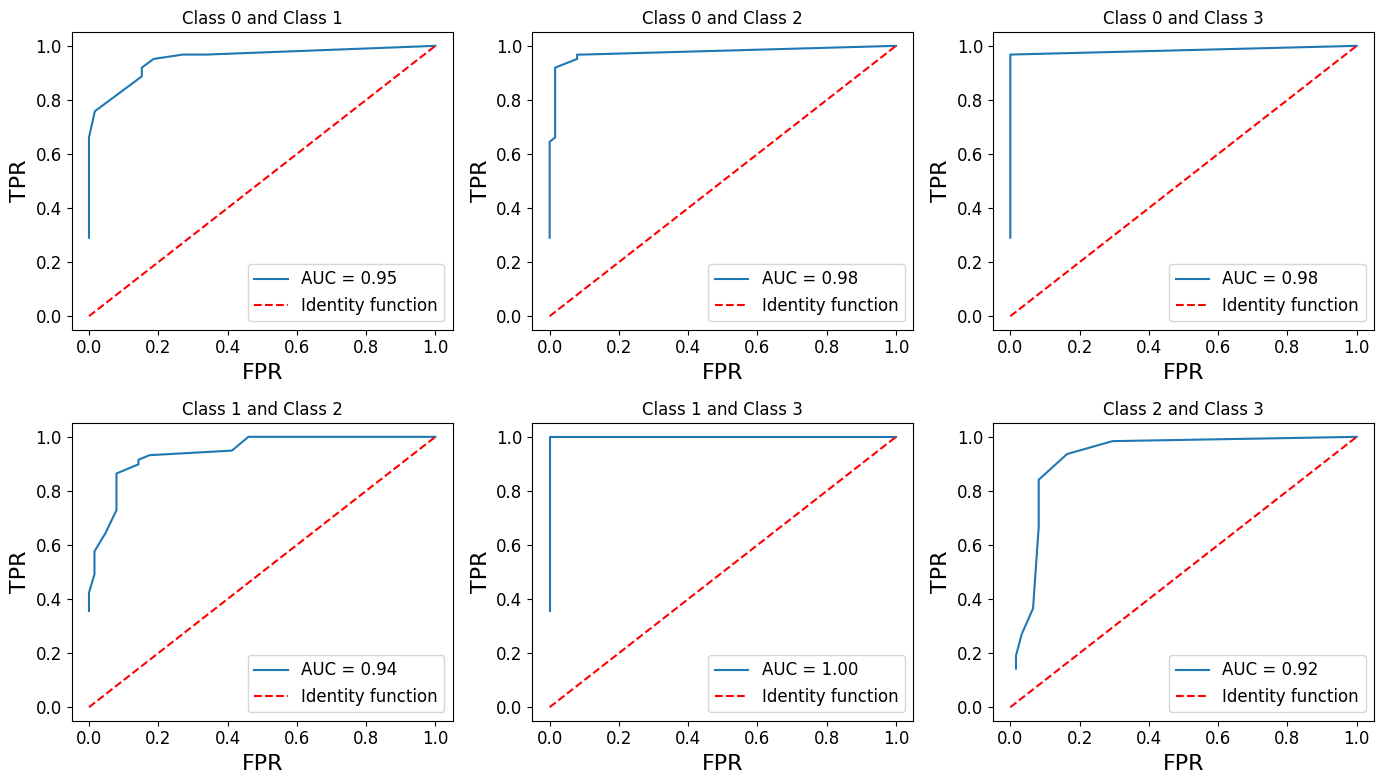

In [20]:
# Define the class pairs and initialise the AUC results
class_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
auc_results = {}

# Create a figure to plot ROC curves
plt.figure(figsize=(14, 8))

# Process each class pair
for i, (class_1, class_2) in enumerate(class_pairs):
    # Extract test samples belonging to the two classes
    class_mask = (y_test == class_1) | (y_test == class_2)
    y_probs = y_test_probs[class_mask]

    # Compute ROC curve and AUC using the roc_curve function
    auc_value, tpr, fpr = roc_curve(y_test[class_mask] == class_1, y_probs[:, class_1])
    auc_results[(class_1, class_2)] = auc_value

    # Plot the ROC curve
    plt.subplot(2, 3, i+1)
    plt.plot(fpr, tpr, label=f'AUC = {auc_value:0.2f}')
    plt.plot([0, 1], [0, 1], 'r--', label='Identity function')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Class {class_1} and Class {class_2}')
    plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

By inspecting the $6$ ROC plots, we find that:

(1) The AUC values for class pairs $(0, 2)$, $(0, 3)$ and $(1, 3)$ are very high, between $0.98$ and $1.00$, indicating that these class pairs can be easily distinguished.

(2) The AUC values for class pairs $(0, 1)$, $(1, 2)$ and $(2, 3)$ are moderately high, between $0.92$ and $0.95$, meaning these class pairs are distinguishable but not as clearly separated as the previous pairs, i.e., there might be some feature overlap.

(3) All the AUC values are close to $1.00$, indicating that the probabilistic decision tree performs very well.

<a name="task-13"></a>

## (1.3) [(index)](#index-task-13)

We move on to train a random forest for multi-class hard classification with 20 decision trees.
First, we need to rewrite all the functions to support random forests, i.e., with bootstrapping.

In [21]:
def gini_split_rf(X, y, min_samples_leaf, m):
    """
    Choose the best feature to split according to criterion using Gini index with bootstrapping.
    Arguments:
        X: features
        y: target
        min_samples_leaf: minimum number of samples in a leaf node
        m: number of features to sample
    Returns:
        gini: Gini index
        split_feature: index of the best feature to split
        split_threshold: threshold of the best feature to split
    """
    # Initialise variables
    gini, split_feature, split_threshold = np.inf, None, None

    # Sample m features without replacement
    features_sampled = rng.choice(X.shape[1], m, replace=False)

    # Iterate over each feature
    for feature in features_sampled:
        # Iterate over each unique value
        for threshold in np.unique(X[:, feature]):
            # Split the dataset
            left_mask = X[:, feature] < threshold

            # Skip if minimum number of samples is not met
            if sum(left_mask) < min_samples_leaf or sum(~left_mask) < min_samples_leaf:
                continue

            # Calculate the Gini index for each dataset and the weighted Gini index
            gini_left = gini_index(y[left_mask])
            gini_right = gini_index(y[~left_mask])
            weighted_gini = (sum(left_mask) * gini_left + sum(~left_mask) * gini_right) / len(y)

            # Update the best split if a lower Gini index is found
            if weighted_gini < gini:
                gini = weighted_gini
                split_feature = feature
                split_threshold = threshold
    
    # Return the best feature and threshold to split
    return gini, split_feature, split_threshold

In [22]:
def build_tree_rf(X, y, depth, max_depth, min_samples_leaf, m):
    """
    Build the decision tree using recursion with bootstrapping.
    Arguments:
        X: features
        y: target
        depth: current depth for this node
        max_depth: maximum depth of the tree
        min_samples_leaf: minimum number of samples in a leaf node
        m: number of features to sample
    Returns:
        (dict): a dictionary denoting the decision tree. Each parent node has 4 attributes:
            1. feature: the feature to split on
            2. threshold: the threshold to split the feature
            3. left: the left child node
            4. right: the right child node
    """
    # Return the majority vote if the stopping criteria are met
    # i.e., all targets are the same, maximum depth is reached, or minimum number of samples is met
    if len(np.unique(y)) == 1 or depth > max_depth or len(y) <= min_samples_leaf:
        return np.bincount(y).argmax()

    # Find the best feature and threshold to split
    gini, feature, threshold = gini_split_rf(X, y, min_samples_leaf, m)

    # Return the majority vote if the best is not found
    if gini == np.inf:
        return np.bincount(y).argmax()

    # Split the dataset and build the tree; return the majority vote if empty
    left_mask = X[:, feature] <= threshold
    if np.sum(left_mask) == 0 or np.sum(~left_mask) == 0:
        return np.bincount(y).argmax()
    else:
        return {
            "feature": feature,
            "threshold": threshold,
            "left": build_tree_rf(X[left_mask], y[left_mask], depth + 1, max_depth, min_samples_leaf, m),
            "right": build_tree_rf(X[~left_mask], y[~left_mask], depth + 1, max_depth, min_samples_leaf, m),
        }

At this point, we can begin building the random forest required.

In [23]:
def build_rf(X, y, B, N_train, max_depth, min_samples_leaf, m):
    """
    Build a random forest using B decision trees with bootstrapped datasets.
    Arguments:
        X: features
        y: target
        B: number of trees
        N_train: number of samples in the training set
        max_depth: maximum depth of the tree
        min_samples_leaf: minimum number of samples in a leaf node
        m: number of features to sample
    Returns:
        trees: a random forest
    """
    trees = []
    for _ in range(B):
        sample = rng.choice(len(y), N_train, replace=True)
        tree = build_tree_rf(X[sample, :], y[sample], depth=0, max_depth=max_depth, min_samples_leaf=min_samples_leaf, m=m)
        trees.append(tree)
    return trees

For the prediction part, we use essentially the same logic except that a majority voting for each sample is required.

In [24]:
def predict_single_rf(x, node):
    """
    Predict for a single data sample.
    Arguments:
        x: a single data sample
        node: a node in the decision tree
    Returns:
        prediction
    """
    if isinstance(node, dict):
        if x[node["feature"]] <= node["threshold"]:
            return predict_single_rf(x, node["left"])
        else:
            return predict_single_rf(x, node["right"])
    else:
        return node

def predict_rf(X, trees):
    """
    Predict for multiple samples using majority voting from all trees in the random forest. 
    Arguments:
        X: features
        trees: a list of decision trees
    Returns:
        predictions
    """
    # Collect predictions from each tree for all samples
    predictions = np.array([[predict_single_rf(x, tree) for x in X] for tree in trees])  # Ensuring x is a single sample

    # Perform majority voting for each sample
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

We initialise arguments given in the question. Specifically, the lecture note mentions that we could use $m\approx\sqrt{p}$ for bootstrapping. 

In [25]:
B = 20  # Number of decision trees
N_train = X_train.shape[0]  # Number of training samples
p = X_train.shape[1]  # Number of features
m = int(np.sqrt(p))  # Number of features randomly sampled at each split

We then train the random forest and compute the accuracy.

In [26]:
# Train the random forest for the given dataset
random_forest = build_rf(X_train, y_train, B=20, N_train=X_train.shape[0], max_depth=10, min_samples_leaf=12, m=m)

# Calculate the accuracy
print(np.mean(predict_rf(X_train, random_forest) == y_train))
print(np.mean(predict_rf(X_test, random_forest) == y_test))

0.8949211908931699
0.8530612244897959


The accuracy of the random forest on the training and test sets is therefore $89.49\%$ and $85.31\%$, respectively. These are better than $86.87\%$ and $82.45\%$, respectively, in the case of (a single) decision tree, indicating better performance.

For the next part, we modify the $\verb|build_tree|$ function to record the Gini importance.

We are given that Gini importance $(x_n)=\displaystyle\frac{1}{B}\sum_{b=1}^{B}\sum_{t\in T_b:j_t=n}p_t\Delta GI(s_t,t)$, where $p_t=N_t/N'$.

We have $N_t=\verb|len(y)|$ and $N'=\verb|N_train|$ as given.

For $\Delta GI(s_t,t)=GI(t)-p_LGI(t_L)-p_RGI(t_R)$, we have $p_L=N_{tL}/N_t$ and over all $t\in T_b:j_t=n$, $N_{tL}$ can be expressed as $\verb|sum(left_mask)|$ . The $p_R$ case is similar, so we can compute $p_LGI(t_L)+p_RGI(t_R)$ by $\verb|(sum(left_mask) * gini_index(y[left_mask]) + sum(~left_mask) * gini_index(y[~left_mask])) / len(y)|$.



In [27]:
def build_tree_gi(X, y, depth, max_depth, min_samples_leaf, m, gini_importance):
    """
    Build the decision tree using recursion with Gini importance.
    Arguments:
        X: features
        y: target
        depth: current depth for this node
        max_depth: maximum depth of the tree
        min_samples_leaf: minimum number of samples in a leaf node
        m: number of features to sample
        gini_importance: array to store Gini importance
    Returns:
        (dict): a dictionary denoting the decision tree. Each parent node has 4 attributes:
            1. feature: the feature to split on
            2. threshold: the threshold to split the feature
            3. left: the left child node
            4. right: the right child node
    """
    # Return the majority vote if the stopping criteria are met
    # i.e., all targets are the same, maximum depth is reached, or minimum number of samples is met
    if len(np.unique(y)) == 1 or depth > max_depth or len(y) <= min_samples_leaf:
        return np.bincount(y).argmax()

    # Find the best feature and threshold to split
    gini, feature, threshold = gini_split_rf(X, y, min_samples_leaf, m)

    # Return the majority vote if the best is not found
    if gini == np.inf:
        return np.bincount(y).argmax()

    # Split the dataset and build the tree; return the majority vote if empty
    left_mask = X[:, feature] <= threshold
    if np.sum(left_mask) == 0 or np.sum(~left_mask) == 0:
        return np.bincount(y).argmax()
    else:
        # Add the Gini importance to this feature
        delta_gini = gini_index(y) - (sum(left_mask) * gini_index(y[left_mask]) + sum(~left_mask) * gini_index(y[~left_mask])) / len(y)
        gini_importance[feature] += (len(y) / N_train) * delta_gini
        return {
            "feature": feature,
            "threshold": threshold,
            "left": build_tree_gi(X[left_mask], y[left_mask], depth + 1, max_depth, min_samples_leaf, m, gini_importance),
            "right": build_tree_gi(X[~left_mask], y[~left_mask], depth + 1, max_depth, min_samples_leaf, m, gini_importance),
        }

We can now account for the $1/B$ factor in the Gini importance when we build the random forest.

In [28]:
def build_rf_gi(X, y, B, max_depth, min_samples_leaf, m):
    """
    Build a random forest using B decision trees with Gini importance.
    Arguments:
        X: features
        y: target
        B: number of trees
        N_train: number of samples in the training set
        max_depth: maximum depth of the tree
        min_samples_leaf: minimum number of samples in a leaf node
        m: number of features to sample
    Returns:
        gini_importance: Gini importance
    """
    gini_importance = np.zeros(p)
    for _ in range(B):
        sample = rng.choice(len(y), N_train, replace=True)
        build_tree_gi(X[sample, :], y[sample], depth=0, max_depth=max_depth, min_samples_leaf=min_samples_leaf, m=m, gini_importance=gini_importance)
    return gini_importance / B

After this, we can just express all Gini importances for the $6$ predictors in terms of relative percentages, and plot a bar graph.

[ 17.74008072   6.78945851  39.89005967 100.           7.24803484
   2.29667891]


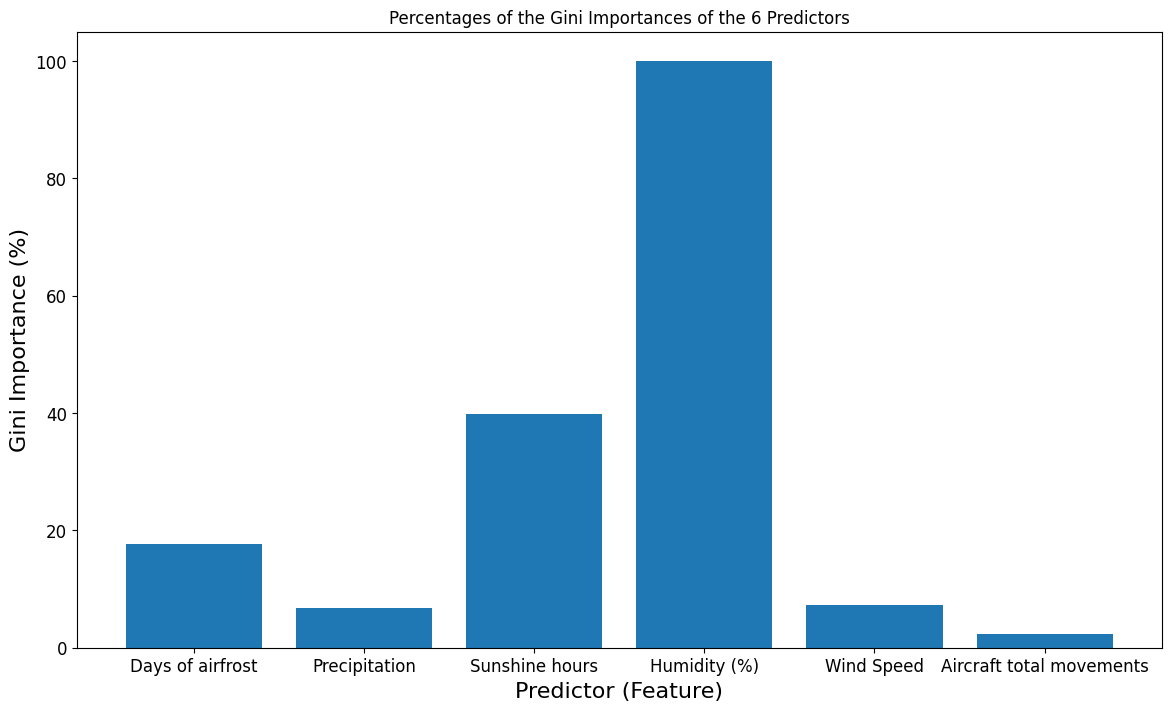

In [29]:
# Train the random forest and compute Gini importance
gini_importance = build_rf_gi(X_train, y_train, B, max_depth=10, min_samples_leaf=12, m=m)

# Express as a percentage of the maximally important feature
gini_importance_percentage = (gini_importance / np.max(gini_importance)) * 100
print(gini_importance_percentage)

# Plot Gini importance
plt.figure(figsize=(14, 8))
plt.bar(features, gini_importance_percentage)
plt.xlabel("Predictor (Feature)")
plt.ylabel("Gini Importance (%)")
plt.title("Percentages of the Gini Importances of the 6 Predictors")
plt.show()

By inspecting the bar plots, we find that:

(1) Humidity (%) is the most relevant predictor with the largest Gini importance.

(2) Days of airfrost and sunshine hours are also crucial.

(3) Precipitation, wind speed and aircraft total movements are the least important features.

<a name="task-14"></a>

## (1.4) [(index)](#index-task-14)

In this part of the problem, we are asked to compute Out-of-Bag (OOB) misclassification errors for different $B$ values.

We are going to choose $B=10, 20, \cdots, 100$ and take note of the value that minimises the OOB error, which can be calculated from the definition.

In [30]:
def build_rf_oob(X, y, B_values, N_train, max_depth, min_samples_leaf, m):
    """
    Return the number of decision trees in the random forest that minimises the OOB error.
    Arguments:
        X: features
        y: target
        B_values: list of values of the number of trees
        N_train: number of samples in the training set
        max_depth: maximum depth of the tree
        min_samples_leaf: minimum number of samples in a leaf node
        m: number of features to sample
    Returns:
        B: the B value that minimises the OOB error
    """
    # Initialise OOB errors
    oob_errors = []

    # Iterate over each B value
    for B in B_values:
        # Bootstrap sample indices
        indices = []

        # Build the random forests
        trees = []
        for _ in range(B):
            sample = rng.choice(len(y), N_train, replace=True)
            indices.append(set(sample))
            tree = build_tree_rf(X[sample, :], y[sample], depth=0, max_depth=max_depth, min_samples_leaf=min_samples_leaf, m=m)
            trees.append(tree)

        # Collect OOB predictions
        oob_votes = {i:[] for i in range(len(y))}
        for i in range(len(y)):
            for b in range(B):
                # If the index is not in the bootstrap sample, predict using the tree
                if i not in indices[b]:
                    oob_votes[i].append(predict_single_rf(X[i], trees[b]))

        # Compute OOB errors
        oob_pred = np.array([max(set(votes), key=votes.count) if votes else -1 for votes in oob_votes.values()])
        valid_oob = oob_pred != -1  # Ignore samples with no OOB predictions
        oob_error = np.mean(oob_pred[valid_oob] != y[valid_oob])
        oob_errors.append(oob_error)

    # Find the B minimising OOB error    
    return B_values[np.argmin(oob_errors)]

# Scan B over values from 10, 20, ..., 100
B_values = np.linspace(10, 100, 10, dtype=int)

# Find the optimal B using OOB error
B = build_rf_oob(X_train, y_train, B_values, N_train, max_depth=10, min_samples_leaf=12, m=m)
print(B)

# Evaluate accuracy on the test set for the random forest with the optimal B
rf_optimal = build_rf(X_train, y_train, B, N_train, max_depth=10, min_samples_leaf=12, m=m)
print(np.mean(predict_rf(X_test, rf_optimal) == y_test))

90
0.8489795918367347


Compared to $82.45\%$ accuracy achieved with a single decision tree, we get a higher accuracy of $84.90\%$ with $B=90$. Notice that $B\neq 100$, so a larger number of decision trees is not always better.

Note also that the code block above takes about $90$ seconds to run, so efficiency is also an issue for larger $B$ values.

<a name="task-2"></a>

# Task 2: Binary classification with the Huberised Support Vector Machine [(index)](#index-task-2)

For this task, we begin by renaming the labels for binary classification. We then redefine features and labels and standardise the datasets as required.

In [31]:
data_train["Weather and flight condition category"] = data_train["Weather and flight condition category"].apply(lambda x: 1 if x == 0 else -1)
data_test["Weather and flight condition category"] = data_test["Weather and flight condition category"].apply(lambda x: 1 if x == 0 else -1)
features = ["Days of airfrost", "Precipitation", "Sunshine hours", "Humidity (%)", "Wind Speed", "Aircraft total movements"]
X_train = data_train[features].values
y_train = data_train["Weather and flight condition category"].values
X_test = data_test[features].values
y_test = data_test["Weather and flight condition category"].values

In [32]:
mean_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)
X_train = (X_train - mean_train) / std_train
X_test = (X_test - mean_train) / std_train

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

We are given the loss function
$$L(\mathbf{w},b)=\frac{1}{2}||\mathbf{w}||^2+\lambda\sum_{i=1}^{N^{\mathrm{train}}}L_c\left(1-\left(\mathbf{x}^{(i)}\cdot\mathbf{w}+b\right)y^{(i)}\right),$$

where the Huber function $L_c$ is defined as
$$L_c(z)=\begin{cases}0,&\text{if }z\leq0,\\\frac{1}{2}z^2,&\text{if }0<z\leq c,\\c\left(z-\frac{c}{2}\right),&\text{if }z>c.\end{cases}$$

We therefore need to consider three cases. Denote $z:=1-\left(\mathbf{x}^{(i)}\cdot\mathbf{w}+b\right)y^{(i)}$.

If $z\leq0$, then $L_c(z)=0$, so its derivative with respect to both $\mathbf{w}$ and $b$ is zero.

If $0<z\leq c$, then $L_c(z)=\frac{1}{2}z^2$, so its derivative with respect to $\mathbf{w}$ is $\frac{\partial L_c}{\partial \mathbf{w}}=-z\mathbf{x}^{(i)}y^{(i)}$ and its derivative with respect to $b$ is $\frac{\partial L_c}{\partial b}=-zy^{(i)}$.

If $z>c$, then $L_c(z)=c\left(z-\frac{c}{2}\right)$, so its derivative with respect to $\mathbf{w}$ is $\frac{\partial L_c}{\partial \mathbf{w}}=-c\mathbf{x}^{(i)}y^{(i)}$ and its derivative with respect to $b$ is $\frac{\partial L_c}{\partial b}=-cy^{(i)}$.

Since $\frac{\partial}{\partial \mathbf{w}}\frac{1}{2}||\mathbf{w}||^2=\mathbf{w}$, we therefore have
$$\frac{\partial L}{\partial\mathbf{w}}=\begin{cases}\mathbf{w},&\text{if }z\leq0,\\ \mathbf{w}-\lambda\displaystyle\sum_{i=1}^{N^{\mathrm{train}}}z\mathbf{x}^{(i)}y^{(i)},&\text{if }0<z\leq c,\\\mathbf{w}-\lambda\displaystyle\sum_{i=1}^{N^{\mathrm{train}}}c\mathbf{x}^{(i)}y^{(i)},&\text{if }z>c,\end{cases}$$

and
$$\frac{\partial L}{\partial b}=\begin{cases}0,&\text{if }z\leq0,\\-\lambda\displaystyle\sum_{i=1}^{N^{\mathrm{train}}}zy^{(i)},&\text{if }0<z\leq c,\\-\lambda\displaystyle\sum_{i=1}^{N^{\mathrm{train}}}cy^{(i)},&\text{if }z>c.\end{cases}$$

We can then describe in code the loss function and its gradient.

In [33]:
def compute_loss(w, X, y, lambda_value):
    """
    Compute the total loss for Huberised SVM.
    Arguments:
        w: vector of weights (incl. bias)
        X: features
        y: labels
        lambda_value: regularisation parameter
    Returns:
        Huber loss function
    """
    s = 1 - (y * (X @ w))
    loss = np.where(s <= 0, 0, np.where(s <= 1, 0.5 * s**2, s - 0.5))
    return (0.5 * np.dot(w, w)) + lambda_value * np.mean(loss)

def calculate_loss_gradient(w, X_batch, y_batch, lambda_value, c):
    """
    Calculate gradient of the loss for Huberised SVM.
    Arguments:
        w: vector of weights (incl. bias)
        X_batch: batch of features
        y_batch: batch of labels
        lambda_value: regularisation parameter
        c: Huber function parameter
    Returns:
        gradient of the loss with respect to w
    """
    # If only one sample is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])

    # Compute loss gradient based on Huber loss cases
    s = 1 - (y_batch * (X_batch @ w))
    distance = np.where(s <= 0, 0, np.where(s <= c, s, c))
    dw = np.zeros(len(w))

    we = w.copy()  # So as not to overwrite w
    we[-1] = 0  # So as not to have b in its derivative when adding the weights

    # Compute the gradient
    for ind, d in enumerate(distance):
        dw += -lambda_value * d * y_batch[ind] * X_batch[ind]
    dw += we

    dw /= len(y_batch)  # average
    return dw

We are now ready to train the Huberised SVM on the standardised training set using mini-batch SGD with given parameters.

In [34]:
def mini_batch_gradient_descent(X, y, batch_size, max_iterations, stop_criterion, learning_rate, lambda_value, print_outcome, c):
    """
    Performs mini-batch stochastic gradient descent for Huberised SVM.
    Arguments:
        X: the feature matrix
        y: the target labels
        batch_size: size of each mini-batch
        max_iterations: maximum number of iterations
        stop_criterion: percentage change in loss function to determine convergence
        learning_rate: learning rate for gradient updates
        lambda_value: regularisation parameter
        print_outcome: whether to print progress during training
        c: Huber function parameter
    Returns:
        weights: optimised weights
        loss_history: history of loss
        iteration_list: list of iteration numbers corresponding to loss values
    """
    # Initialise weights to zero
    weights = np.zeros(X.shape[1])
    nth = 0
    prev_loss = np.inf  # Initialise starting loss as infinity
    loss_history = []  # Track loss values
    iteration_list = []  # Track iteration numbers

    for iteration in range(1, max_iterations + 1):
        # Shuffle data to prevent repeating update cycles
        indices = rng.permutation(len(y))
        X_shuffled, y_shuffled = X[indices], y[indices]

        # Create mini-batches
        for start_idx in range(0, len(y), batch_size):
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Compute the gradient for the mini-batch
            gradient = calculate_loss_gradient(weights, X_batch, y_batch, lambda_value, c)

            # Update weights
            weights = weights - (learning_rate * gradient)

        # Check for convergence at 2^nth iteration or last iteration
        if iteration == 2**nth or iteration == max_iterations:
            # Compute the current loss
            loss = compute_loss(weights, X, y, lambda_value)
            if print_outcome:
                print(f'Iteration: {iteration}, Loss: {loss:.6f}')

            # Check if the stop criterion is met
            if abs(prev_loss - loss) < stop_criterion * prev_loss:
                return weights, loss_history, iteration_list

            # Update tracking variables
            prev_loss = loss
            iteration_list.append(iteration)
            loss_history.append(loss)
            nth += 1

    return weights, loss_history, iteration_list

# Training the model
weights, loss_history, iterations = mini_batch_gradient_descent(
    X_train, y_train, batch_size=32, max_iterations=2000, stop_criterion=0.001,
    learning_rate=1e-4, lambda_value=100, print_outcome=True, c=1
)
print("Training finished.")

Iteration: 1, Loss: 46.726897
Iteration: 2, Loss: 44.781764
Iteration: 4, Loss: 42.495174
Iteration: 8, Loss: 40.199825
Iteration: 16, Loss: 37.973674
Iteration: 32, Loss: 36.389209
Iteration: 64, Loss: 35.810226
Iteration: 128, Loss: 35.740231
Iteration: 256, Loss: 35.754197
Training finished.


We also produce a plot to show the training convergence.

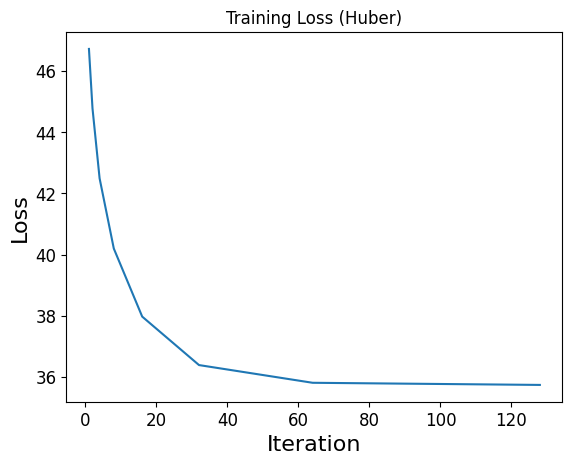

In [35]:
# Plot convergence
plt.plot(iterations, loss_history)
plt.title('Training Loss (Huber)')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

After this, we train another SVM binary classifier with standard hinge loss.

In [36]:
def compute_hinge_loss(w, X, y, lambda_value):
    """
    Compute the total hinge loss for SVM.
    Arguments:
        w: vector of weights (incl. bias)
        X: features
        y: labels
        lambda_value: regularisation parameter
    Returns:
        Hinge loss function
    """
    loss = np.maximum(0, 1 - (y * (X @ w)))
    return (0.5 * np.dot(w, w)) + lambda_value * np.mean(loss)

def calculate_hinge_loss_gradient(w, X_batch, y_batch, lambda_value):
    """
    Calculate gradient of the hinge loss for SVM.
    Arguments:
        w: vector of weights (incl. bias)
        X_batch: batch of features
        y_batch: batch of labels
        lambda_value: regularisation parameter
    Returns:
        dw: gradient of the loss with respect to w
    """
    # If only one sample is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])

    # Compute loss gradient based on Huber loss cases
    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    we = w.copy()  # So as not to overwrite w
    we[-1] = 0  # So as not to have b in its derivative when adding the weights

    # Compute the gradient
    for ind, d in enumerate(distance):
        if d > 0:
            dw += -lambda_value * y_batch[ind] * X_batch[ind]
    dw += we

    dw /= len(y_batch)  # average
    return dw

def mini_batch_gradient_descent_hinge(X, y, batch_size, max_iterations, stop_criterion, learning_rate, lambda_value, print_outcome):
    """
    Performs mini-batch stochastic gradient descent for SVM.
    Arguments:
        X: the feature matrix
        y: the target labels
        batch_size: size of each mini-batch
        max_iterations: maximum number of iterations
        stop_criterion: percentage change in loss function to determine convergence
        learning_rate: learning rate for gradient updates
        lambda_value: regularisation parameter
        print_outcome: whether to print progress during training
    Returns:
        weights: optimised weights
        loss_history: history of loss
        iteration_list: list of iteration numbers corresponding to loss values
    """
    # Initialise weights to zero
    weights = np.zeros(X.shape[1])
    nth = 0
    prev_loss = np.inf  # Initialise starting loss as infinity
    loss_history = []  # Track loss values
    iteration_list = []  # Track iteration numbers

    for iteration in range(1, max_iterations + 1):
        # Shuffle data to prevent repeating update cycles
        indices = rng.permutation(len(y))
        X_shuffled, y_shuffled = X[indices], y[indices]

        # Create mini-batches
        for start_idx in range(0, len(y), batch_size):
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Compute the gradient for the mini-batch
            gradient = calculate_hinge_loss_gradient(weights, X_batch, y_batch, lambda_value)

            # Update weights
            weights = weights - (learning_rate * gradient)

        # Check for convergence at 2^nth iteration or last iteration
        if iteration == 2**nth or iteration == max_iterations:
            # Compute the current loss
            loss = compute_hinge_loss(weights, X, y, lambda_value)
            if print_outcome:
                print(f'Iteration: {iteration}, Loss: {loss:.6f}')

            # Check if the stop criterion is met
            if abs(prev_loss - loss) < stop_criterion * prev_loss:
                return weights, loss_history, iteration_list

            # Update tracking variables
            prev_loss = loss
            iteration_list.append(iteration)
            loss_history.append(loss)
            nth += 1

    return weights, loss_history, iteration_list

Iteration: 1, Loss: 95.870951
Iteration: 2, Loss: 91.778237
Iteration: 4, Loss: 85.258566
Iteration: 8, Loss: 79.124539
Iteration: 16, Loss: 73.351548
Iteration: 32, Loss: 68.016788
Iteration: 64, Loss: 66.953359
Iteration: 128, Loss: 66.599499
Iteration: 256, Loss: 66.658100
Training finished.


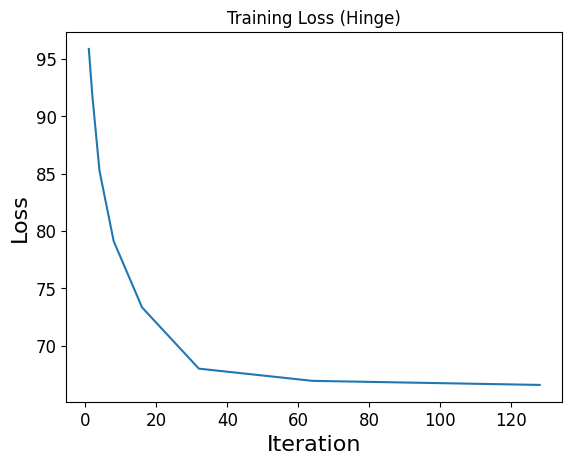

In [37]:
# Training the model
weights_hinge, loss_history_hinge, iteration_hinge = mini_batch_gradient_descent_hinge(
    X_train, y_train, batch_size=32, max_iterations=2000, stop_criterion=0.001,
    learning_rate=1e-4, lambda_value=100, print_outcome=True
)
print("Training finished.")

# Plot convergence
plt.plot(iteration_hinge, loss_history_hinge)
plt.title('Training Loss (Hinge)')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

To compare between the $2$ SVMs, we compare the accuracy on the standardised test set and the number of training data points that fall outside the margin (otm).

In [38]:
# Compute the accuracy
print("Huber accuracy:", np.mean(np.sign(X_test @ weights) == y_test))
print("Hinge accuracy:", np.mean(np.sign(X_test @ weights_hinge) == y_test))

# Compute the number of training points outside the margin
print("Huber otm points:", np.sum(y_test * (X_test @ weights) < 1))
print("Hinge otm points:", np.sum(y_test * (X_test @ weights_hinge) < 1))

Huber accuracy: 0.7142857142857143
Hinge accuracy: 0.689795918367347
Huber otm points: 217
Hinge otm points: 158


We also generate plots illustrating the modified Huber function alongside the hinge loss as a function of $yf(x)$.

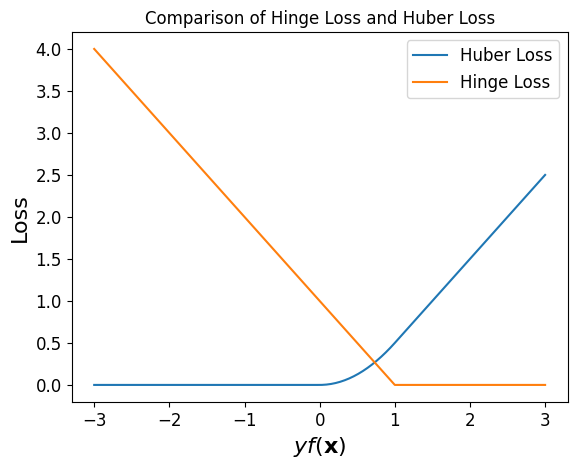

In [39]:
# Generate data points
x_values = np.linspace(-3, 3, 100)
huber_loss = np.where(x_values <= 0, 0, np.where(x_values <= 1, 0.5 * x_values**2, x_values - 0.5))
hinge_loss = np.maximum(0, 1 - x_values)

# Plot both functions
plt.title("Comparison of Hinge Loss and Huber Loss")
plt.plot(x_values, huber_loss, label="Huber Loss")
plt.plot(x_values, hinge_loss, label="Hinge Loss")
plt.xlabel(r"$yf(\mathbf{x})$")
plt.ylabel("Loss")
plt.legend()
plt.show()

From the plot and the 2 quantities above, we can say that:

(1) The Hinge loss is linear while the Huber loss has a quadratic region, so the Huber loss is smoother and thus less strict with margin classification.

(2) The Hinge loss SVM has a lower accuracy while the Huberised SVM has a lower number of otm points, so the Hinge loss has fewer violations while the Huber loss is more robust to data variations or outliers.


<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

We now write a function that performs $T$-fold cross-validation for hyperparameter tuning of the Huberised SVM that supports variations in $c$ and $\lambda$ values. It will return the optimal $c$ and $\lambda$ values with the highest accuracy.

In [40]:
def cross_validation_huber_svm(X_train, y_train, c_values, lambda_values, T):
    """
    Perform T-fold cross-validation for the Huberised SVM.
    Arguments:
        X_train: feature matrix
        y_train: labels
        c_values: list of c values to test
        lambda_values: list of lambda values to test
        T: number of folds
    Returns:
        best_hyperparams: best hyperparameters (c, lambda) based on highest accuracy
    """
    # Split the data into T folds
    folds = np.array_split(np.arange(len(y_train)), T)
    best_acc = 0
    best_hyperparams = None

    # Iterate over all hyperparameters
    for c in c_values:
        for lambda_reg in lambda_values:
            # Perform T-fold cross-validation
            scores = []
            for i in range(T):
                train_idx = np.hstack([folds[j] for j in range(T) if j != i])
                val_idx = folds[i]
                X_tr, y_tr = X_train[train_idx], y_train[train_idx]
                X_val, y_val = X_train[val_idx], y_train[val_idx]

                # Train on the training fold
                weights, _, _ = mini_batch_gradient_descent(
                    X_tr, y_tr, batch_size=32, max_iterations=2000, stop_criterion=0.001,
                    learning_rate=1e-4, lambda_value=lambda_reg, print_outcome=False, c=c
                )

                # Evaluate on the validation fold
                scores.append(np.mean(np.sign(X_val @ weights) == y_val))

            # Compute average accuracy and update hyperparameters if necessary
            avg_acc = np.mean(scores)
            if avg_acc > best_acc:
                best_acc = avg_acc
                best_hyperparams = (c, lambda_reg)

    # Return the best hyperparameters
    return best_hyperparams

First, we produce plots showing the modified Huber function as a function of $yf(x)$ for the different values of $c$.

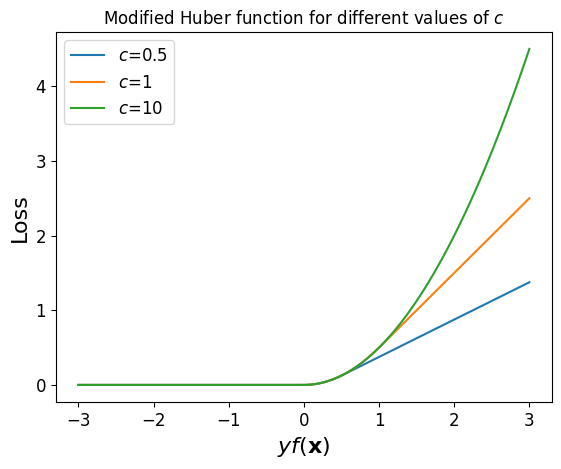

In [41]:
c_values = [0.5, 1, 10]
for c in c_values:
    huber_loss = np.where(x_values <= 0, 0, np.where(x_values <= c, 0.5 * x_values**2, c * (x_values - c / 2)))
    plt.plot(x_values, huber_loss, label=f"$c$={c}")
plt.xlabel(r"$y f(\mathbf{x})$")
plt.ylabel("Loss")
plt.title("Modified Huber function for different values of $c$")
plt.legend()
plt.show()

Next, we run cross-validation to find the optimal values of $c$ and $\lambda$ for the Huberised SVM.

In [42]:
# Run cross-validation
lambda_values = [1, 100, 10000]
best_hyperparams = cross_validation_huber_svm(X_train, y_train, c_values, lambda_values, T=5)
print(best_hyperparams)

(0.5, 10000)


After that, we retrain the Huberised SVM with optimal hyperparameters found and compare with the accuracy before.

In [43]:
weights_optimised, _, _ = mini_batch_gradient_descent(
    X_train, y_train, batch_size=32, max_iterations=2000, stop_criterion=0.001,
    learning_rate=1e-4, lambda_value=best_hyperparams[1], print_outcome=False, c=best_hyperparams[0]
)

print(np.mean(np.sign(X_test @ weights_optimised) == y_test))
print(np.mean(np.sign(X_test @ weights) == y_test))

0.673469387755102
0.7142857142857143


We also compute the balanced accuracy using the definition with true positive.

In [44]:
def compute_balanced_accuracy(y_true, y_pred):
    """
    Compute balanced accuracy.
    Arguments:
        y_true: ground truth labels
        y_pred: predicted labels
    Returns:
        balanced accuracy
    """
    # Compute recall for each class
    unique_classes = np.unique(y_true)
    recall_per_class = []
    for cls in unique_classes:
        true_positive = np.sum((y_true == cls) & (y_pred == cls))
        total_actual = np.sum(y_true == cls)
        recall = true_positive / total_actual if total_actual > 0 else 0
        recall_per_class.append(recall)

    # Return the average recall
    return np.mean(recall_per_class)

In [45]:
print(compute_balanced_accuracy(y_test, np.sign(X_test @ weights_optimised)))
print(compute_balanced_accuracy(y_test, np.sign(X_test @ weights)))

0.7600916622598273
0.8034108937070333


We found that, with optimal hyperparameters by cross-validation, both the test accuracy and the balanced accuracy are actually lower than before (but still very close). This is probably due to some error in my implementation, but maybe in this case hyperparameter tuning just does not lead to significant improvements.

<a name="task-3"></a>

# Task 3: Regression with the Multi-Layer Perceptron [(index)](#index-task-3)

Now we move on to the MLP regression model for predicting the minimal temperature and the maximal temperature.

<a name="task-31"></a>

## (3.1) [(index)](#index-task-31)

To implement the MLP, we first prepare the datasets as instructed.

In [46]:
features = ["Days of airfrost", "Precipitation", "Sunshine hours", "Humidity (%)", "Wind Speed", "Aircraft total movements"]
target_min = "Runway surface minimal temperature"
target_max = "Runway surface maximal temperature"
X_train = data_train[features].values
y_train = data_train[[target_min, target_max]].values
X_test = data_test[features].values
y_test = data_test[[target_min, target_max]].values

We will use MLP class provided in the Week 5 notebook with $\verb|seed=2|$. We omit all comments for clarity and conciseness.

In [47]:
def dense(X, W, b):
    a = np.vstack([W @ x + b for x in X])
    return a
def relu_activation(a):
    h = np.maximum(a, 0.)
    return h
def grad_relu_activation(a):
    grad = np.zeros_like(a)
    grad[a>0] = 1
    return grad
activation_table = {
    "relu": relu_activation,
    "identity": lambda x: x
}
grad_activation_table = {
    "relu": grad_relu_activation,
    "identity": lambda x: np.ones_like(x)
}
class MLP:
    def __init__(self):
        self.layers = []
        self.rng = np.random.default_rng(2)
    def n_parameters(self):
        return sum(l["b"].size + l["W"].size for l in self.layers)
    def n_layers(self):
        return len(self.layers) + 1 if len(self.layers) > 0 else 0
    def layer_dim(self, index):
        return self.layers[index]["W"].shape
    def add_layer(self, in_dim, out_dim, activation="identity"):
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."
        self.layers.append({
            "index": len(self.layers),
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            "b": np.zeros(out_dim),
            "activation": activation
        })
    def predict(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)
        forward_pass = [{"index": 0, "a": X, "h": X}]
        for k in range(1, len(self.layers)):
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = activation_table[self.layers[k]["activation"]]
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})
        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"])
        return y_hat, forward_pass

We then consider the compound loss function given. The loss for each sample $i$ is $$L_i=(T_{\min} - \hat{T}_{\min})^2 + (T_{\max} - \hat{T}_{\max})^2 + \lambda\max(0, \hat{T}_{\min} - \hat{T}_{\max}).$$

Therefore, we can just compute all the losses and take the average.

In [48]:
def compound_loss(y_true, y_pred, lambda_value):
    """
    Compute the compound loss function.
    Arguments:
        y_true: ground truth labels
        y_pred: predicted labels
        lambda_value: lambda parameter
    Returns:
        compound loss function
    """
    # Separate out columns
    T_min = y_true[:, 0]
    T_max = y_true[:, 1]
    T_min_hat = y_pred[:, 0]
    T_max_hat = y_pred[:, 1]

    # Average over the batch
    return np.mean((T_min - T_min_hat)**2 + (T_max - T_max_hat)**2 + lambda_value * np.maximum(0.0, T_min_hat - T_max_hat), keepdims=True)

After that, we take the derivative with respect to $\hat{T}_{\min}$ and $\hat{T}_{\max}$ respectively to get the gradient,
$$\frac{\partial L_i}{\partial\hat{T}_{\min}}=2(\hat{T}_{\min} - T_{\min}) + \lambda\cdot\mathbb{I}(\hat{T}_{\min} - \hat{T}_{\max}>0),$$
$$\frac{\partial L_i}{\partial\hat{T}_{\max}}=2(\hat{T}_{\max} - T_{\max}) - \lambda\cdot\mathbb{I}(\hat{T}_{\min} - \hat{T}_{\max}>0),$$
where $\mathbb{I}$ is the indicator function.

In [49]:
def grad_compound_loss(y_true, y_pred, lambda_value):
    """
    Compute the gradient of the compound loss function.
    Arguments:
        y_true: ground truth labels
        y_pred: predicted labels
        lambda_value: lambda parameter
    Returns:
        gradient of the compound loss function
    """
    # Separate out columns
    T_min = y_true[:, 0]
    T_max = y_true[:, 1]
    T_min_hat = y_pred[:, 0]
    T_max_hat = y_pred[:, 1]

    # Indicator function
    indicator = T_min_hat - T_max_hat > 0.0

    # Gradient with respect to both T_min_hat and T_max_hat
    grad_min = 2 * (T_min_hat - T_min) + lambda_value * indicator
    grad_max = 2 * (T_max_hat - T_max) - lambda_value * indicator
    return np.column_stack([grad_min, grad_max])

We are now ready to set up the mini-batch SGD method. Again we will just take the version given in the notebook, so we omit any comments etc. for clarity.

In [50]:
def backpropagate(layers, forward_pass, delta_output):
    gradients = []
    delta = delta_output
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        h = forward_computes["h"]
        gradients.append({"W": (delta.T @ h) / h.shape[0], "b": delta.mean(axis=0)})
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di for (gi, di) in zip(grad_activation, delta)])
    gradients = list(reversed(gradients))
    return gradients

def sgd_step(X, y, mlp, lambda_value, learning_rate):
    y_hat, forward_pass = mlp.predict(X)
    delta_output = grad_compound_loss(y, y_hat, lambda_value)
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"]
        b = layer["b"] - learning_rate * grad["b"]
        updated_layers.append({"W": W, "b": b, "activation": layer["activation"], "index": layer["index"]})
    return updated_layers

def r2_score(y, y_hat):
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()
    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res / ss_tot)

def sgd(X_train, y_train, X_test, y_test, mlp, lambda_value, learning_rate, n_epochs, minibatchsize, seed=2):
    rng = np.random.default_rng(seed)
    n_iterations = int(np.ceil(len(y_train) / minibatchsize))
    losses_train = []
    losses_test = []
    for i in range(n_epochs):
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]
        for j in range(n_iterations):
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            updated_layers = sgd_step(X_batch, y_batch, mlp, lambda_value, learning_rate)
            mlp.layers = updated_layers
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(compound_loss(y_train, y_hat_train, lambda_value).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(compound_loss(y_test, y_hat_test, lambda_value).squeeze())
    return mlp, losses_train, losses_test

Let us now substitute the parameters given and train the network using the $\verb|MLP|$ class and SGD. We will compute the $R^2$ values too.

In [51]:
lambda_values = [0, 100, 500]
learning_rate = 5e-5
n_epochs = 200
minibatchsize = 20
results = {}
for lambda_value in lambda_values:
    mlp = MLP()
    mlp.add_layer(in_dim=6, out_dim=20, activation="identity")
    mlp.add_layer(in_dim=20, out_dim=20, activation="relu")
    mlp.add_layer(in_dim=20, out_dim=2, activation="identity")
    mlp, losses_train, losses_test = sgd(X_train, y_train, X_test, y_test, mlp, lambda_value, learning_rate, n_epochs, minibatchsize)
    y_hat_train, _ = mlp.predict(X_train)
    y_hat_test, _ = mlp.predict(X_test)
    r2_train = r2_score(y_train, y_hat_train)
    r2_test = r2_score(y_test, y_hat_test)
    print(f"λ = {lambda_value}: R^2 train = {r2_train}, R^2 test = {r2_test}")
    results[lambda_value] = {"train": losses_train, "test": losses_test}

/var/folders/v6/jnr1_8rj2c98dh99fj_fs4ph0000gn/T/ipykernel_34445/359352431.py:6: RuntimeWarning: overflow encountered in matmul
  gradients.append({"W": (delta.T @ h) / h.shape[0], "b": delta.mean(axis=0)})
/var/folders/v6/jnr1_8rj2c98dh99fj_fs4ph0000gn/T/ipykernel_34445/359352431.py:9: RuntimeWarning: overflow encountered in matmul
  delta = np.stack([np.diag(gi) @ layer["W"].T @ di for (gi, di) in zip(grad_activation, delta)])
/var/folders/v6/jnr1_8rj2c98dh99fj_fs4ph0000gn/T/ipykernel_34445/359352431.py:6: RuntimeWarning: invalid value encountered in matmul
  gradients.append({"W": (delta.T @ h) / h.shape[0], "b": delta.mean(axis=0)})
/var/folders/v6/jnr1_8rj2c98dh99fj_fs4ph0000gn/T/ipykernel_34445/359352431.py:9: RuntimeWarning: invalid value encountered in matmul
  delta = np.stack([np.diag(gi) @ layer["W"].T @ di for (gi, di) in zip(grad_activation, delta)])


λ = 0: R^2 train = nan, R^2 test = nan
λ = 100: R^2 train = nan, R^2 test = nan
λ = 500: R^2 train = nan, R^2 test = nan


Unfortunately, that resulted in $\verb|nan|$ which is probably due to some incorrect handling of data. We will try again with standardised dataset.

In [52]:
mean_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)
X_train = (X_train - mean_train) / std_train
X_test = (X_test - mean_train) / std_train

In [53]:
lambda_values = [0, 100, 500]
results = {}
for lambda_value in lambda_values:
    mlp = MLP()
    mlp.add_layer(in_dim=6, out_dim=20, activation="identity")
    mlp.add_layer(in_dim=20, out_dim=20, activation="relu")
    mlp.add_layer(in_dim=20, out_dim=2, activation="identity")
    mlp, losses_train, losses_test = sgd(X_train, y_train, X_test, y_test, mlp, lambda_value, learning_rate, n_epochs, minibatchsize)
    y_hat_train, _ = mlp.predict(X_train)
    y_hat_test, _ = mlp.predict(X_test)
    r2_train = r2_score(y_train, y_hat_train)
    r2_test = r2_score(y_test, y_hat_test)
    print(f"λ = {lambda_value}: R^2 train = {r2_train}, R^2 test = {r2_test}")
    results[lambda_value] = {"train": losses_train, "test": losses_test}

λ = 0: R^2 train = 0.8867155152591334, R^2 test = 0.8889255721444743
λ = 100: R^2 train = 0.8870152303086244, R^2 test = 0.8893053539975838
λ = 500: R^2 train = 0.887069822033189, R^2 test = 0.8894577298098522


We get the correct $R^2$ values this time. We can see that the $R^2$ score is slightly higher for the test set in all cases, and a higher $\lambda$ value gives a slightly larger $R^2$ value. The differences are not huge however, with all values being approximately equal to $0.89$.

We also track the compound loss function on the training set and plot its trend as a function of the number of epochs. As can be seen in the plots, there isn't much difference either for different values of $\lambda$.

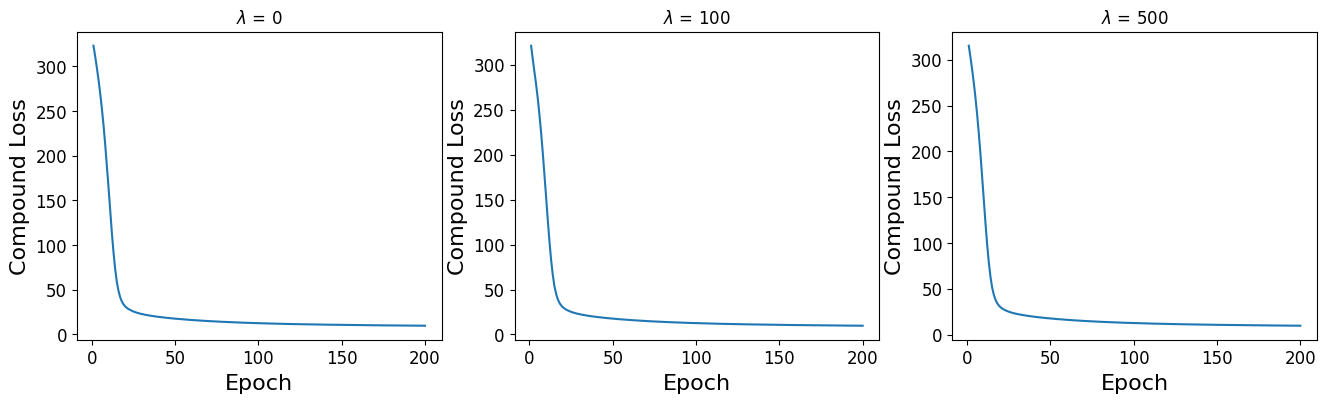

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
epochs = np.arange(1, n_epochs + 1)
for i, lambda_value in enumerate(lambda_values):
    ax = axs[i]
    losses_train = results[lambda_value]["train"]
    # losses_test = results[lambda_value]["test"]
    ax.plot(epochs, losses_train, label="Train")
    # ax.plot(epochs, losses_test, label="Test")
    ax.set(title=f"$\\lambda$ = {lambda_value}", xlabel="Epoch", ylabel="Compound Loss")
    # ax.legend()
plt.show()

This is because that the compound loss function given is actually the MSE with a constraint term $\lambda\max(0, \hat{T}_{\min} - \hat{T}_{\max})$ that basically ensures that the minimum should not be predicted to be greater than the maximum. The hyperparameter $\lambda$ controls this term, but since cases where $\hat{T}_{\min} > \hat{T}_{\max}$ are rare, adjusting the value of $\lambda$ does not affect the result by a lot.

<a name="task-32"></a>

## (3.2) [(index)](#index-task-32)

We will now design a version of SGD with dropout.

In [55]:
def sgd_with_dropout(X_train, y_train, X_test, y_test, mlp, lambda_value, learning_rate, n_epochs, minibatchsize, seed=2):
    '''
    Perform stochastic gradient descent with dropout.
    Arguments:
        X_train: training features
        y_train: training labels
        X_test: testing features
        y_test: testing labels
        mlp: the MLP model
        lambda_value: the lambda value
        learning_rate: the learning rate
        n_epochs: the number of epochs
        minibatchsize: the minibatch size
        seed: the random seed
    Returns:
        mlp: the trained MLP model
        losses_train: the training losses
        losses_test: the testing losses
    '''
    rng = np.random.default_rng(seed)
    n_iterations = int(np.ceil(len(y_train) / minibatchsize))
    losses_train = []
    losses_test = []
    for i in range(n_epochs):
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]
        for j in range(n_iterations):
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_hat, forward_pass = mlp.predict(X_batch)
            # Apply dropout (only during training)
            for layer in mlp.layers:
                if "dropout" in layer:
                    mask = (rng.random(layer["W"].shape) > layer["dropout"]) / (1 - layer["dropout"])
                    layer["W"] *= mask  # Apply dropout scaling
            # Update layers via SGD
            gradients = backpropagate(mlp.layers, forward_pass, grad_compound_loss(y_batch, y_hat, lambda_value))
            for layer, grad in zip(mlp.layers, gradients):
                layer["W"] -= learning_rate * grad["W"]
                layer["b"] -= learning_rate * grad["b"]
        losses_train.append(compound_loss(y_train, mlp.predict(X_train)[0], lambda_value).squeeze())
        losses_test.append(compound_loss(y_test, mlp.predict(X_test)[0], lambda_value).squeeze())
    return mlp, losses_train, losses_test

To suit the need for this question, we design a function specifically for the MLP architcture.

In [56]:
def build_mlp(with_dropout):
    mlp = MLP()
    mlp.add_layer(in_dim=6, out_dim=100, activation="identity")
    mlp.add_layer(in_dim=100, out_dim=200, activation="relu")
    mlp.add_layer(in_dim=200, out_dim=300, activation="relu")
    mlp.add_layer(in_dim=300, out_dim=100, activation="relu")
    mlp.add_layer(in_dim=100, out_dim=100, activation="relu")
    if with_dropout:
        mlp.layers[-1]["dropout"] = 0.1
    mlp.add_layer(in_dim=100, out_dim=2, activation="identity")
    return mlp

Then we train MLPs with or without dropout and compare their $R^2$ values.

In [57]:
lambda_value = 0
mlp_no_dropout = build_mlp(with_dropout=False)
mlp_no_dropout, losses_train_no_dropout, losses_test_no_dropout = sgd_with_dropout(X_train, y_train, X_test, y_test, mlp_no_dropout, lambda_value, learning_rate, n_epochs, minibatchsize)
r2_train = r2_score(y_train, mlp_no_dropout.predict(X_train)[0])
r2_test = r2_score(y_test, mlp_no_dropout.predict(X_test)[0])
print(f"λ = {lambda_value} without dropout: R^2 train = {r2_train}, R^2 test = {r2_test}")

λ = 0 without dropout: R^2 train = 0.9531920634260052, R^2 test = 0.9478018880322865


In [58]:
mlp_dropout = build_mlp(with_dropout=True)
mlp_dropout, losses_train_dropout, losses_test_dropout = sgd_with_dropout(X_train, y_train, X_test, y_test, mlp_dropout, lambda_value, learning_rate, n_epochs, minibatchsize)
r2_train = r2_score(y_train, mlp_dropout.predict(X_train)[0])
r2_test = r2_score(y_test, mlp_dropout.predict(X_test)[0])
print(f"λ = {lambda_value} with dropout: R^2 train = {r2_train}, R^2 test = {r2_test}")

λ = 0 with dropout: R^2 train = 0.8862647613008992, R^2 test = 0.8784373724062601


By comparison, we have that the $R^2$ value for MLP without dropout is larger than that with dropout.

We now plot histogram of the post-activations of the $4^{\text{th}}$ hidden layer.

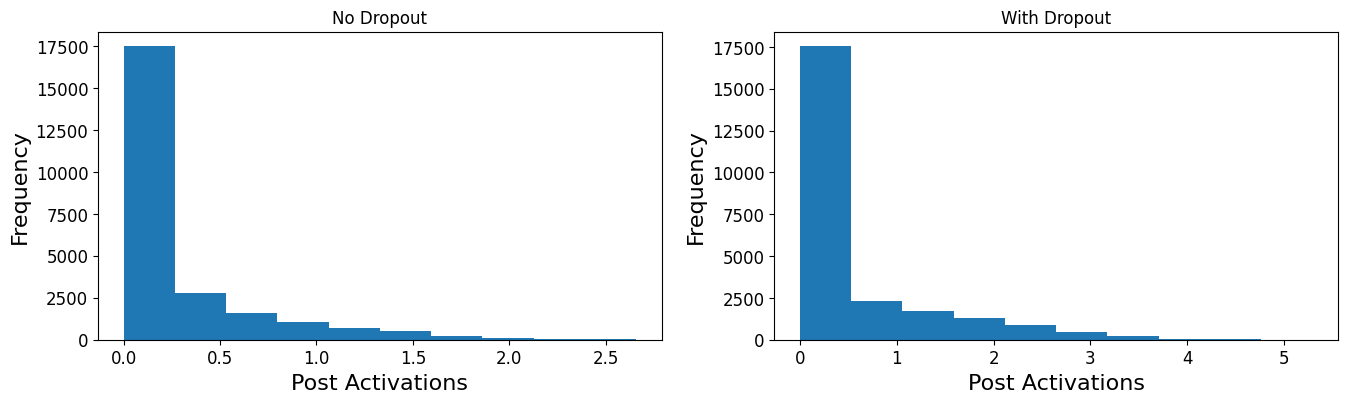

In [59]:
_, forward_pass_no_dropout = mlp_no_dropout.predict(X_test)
pa_no_dropout = forward_pass_no_dropout[4]["h"].flatten()
_, forward_pass_dropout = mlp_dropout.predict(X_test)
pa_dropout = forward_pass_dropout[4]["h"].flatten()
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].hist(pa_no_dropout)
axs[0].set(title="No Dropout", xlabel="Post Activations", ylabel="Frequency")
axs[1].hist(pa_dropout)
axs[1].set(title="With Dropout", xlabel="Post Activations", ylabel="Frequency")
plt.show()

We see that histogram based on MLP with or without dropout is basically the same.

We plot the loss function on the train and test set against the number of epochs as well.

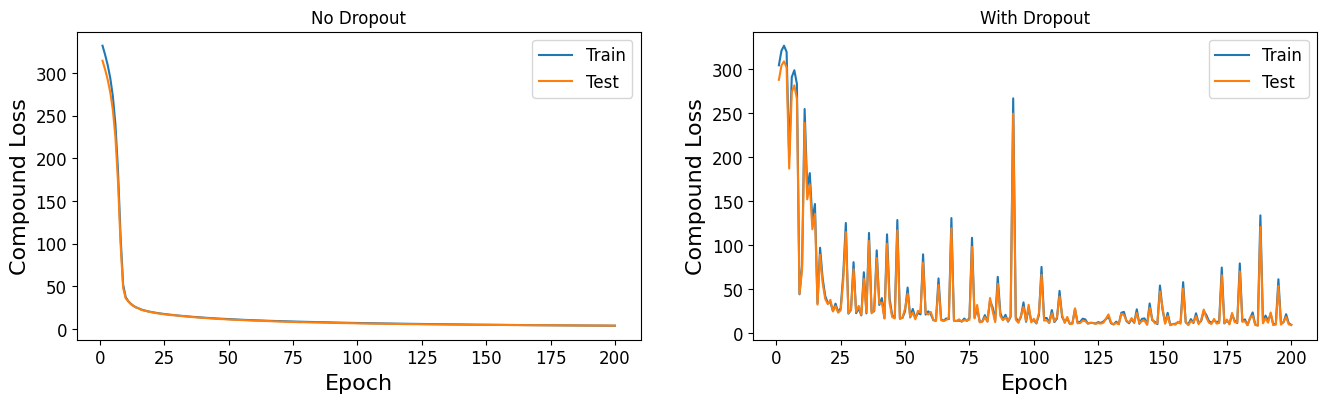

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
epochs = np.arange(1, n_epochs + 1)
axs[0].plot(epochs, losses_train_no_dropout, label="Train")
axs[0].plot(epochs, losses_test_no_dropout, label="Test")
axs[0].legend()
axs[0].set(title="No Dropout", xlabel="Epoch", ylabel="Compound Loss")
axs[1].plot(epochs, losses_train_dropout, label="Train")
axs[1].plot(epochs, losses_test_dropout, label="Test")
axs[1].legend()
axs[1].set(title="With Dropout", xlabel="Epoch", ylabel="Compound Loss")
plt.show()

The left plot shows a smooth loss decrease, indicating stable training but potential overfitting. The right plot exhibits high fluctuations, suggesting regularisation that prevents overfitting but introduces instability.